In [129]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import t as student
from scipy.integrate import quad
from numpy.linalg import eigvals
from scipy.spatial import ConvexHull
from joblib import Parallel, delayed


# Moment conditions for $p$ = 1

## DAR(1)

In [112]:
T = 20000  # samples
nu = 10000
eta = student.rvs(df=nu, size=T) * np.sqrt((nu - 2) / nu)  # eta ~ student-t(0,1)

step = 500  # grid resolution
tolerance = 0.01  # tolerance

# Define ranges for rho and alpha
rho_range = np.linspace(-1.5, 1.5, step)
alpha_range = np.linspace(0.01, 10, step)

frac_moment_points = []
first_moment_points = []
second_moment_points = []

for alpha in alpha_range:
    for rho in rho_range:
        
        # Fractional moment condition
        frac_conditon = np.mean(np.log(np.abs(rho + np.sqrt(alpha) * eta)))
        
        if np.isclose(frac_conditon, 0, atol=tolerance):
            frac_moment_points.append([rho, alpha])
        
        
        # Absolute first-order moment condition
        first_moment = np.mean(np.abs(rho + np.sqrt(alpha) * eta))

        if np.isclose(first_moment, 1, atol=tolerance):
            first_moment_points.append([rho, alpha])

# Second-order moment condition
for rho in rho_range:
    alpha = 1 - rho**2
    if alpha > 0:  # Ensure alpha is valid
        second_moment_points.append([rho, alpha])


# Convert results to numpy arrays
frac_moment = np.array(frac_moment_points)
first_moment = np.array(first_moment_points)
second_moment = np.array(second_moment_points)

In [132]:
# Parameters
T = 30000  # samples
nu = 10000
step = 1000  # grid resolution
tolerance = 0.01  # tolerance

# Generate eta and define ranges
eta = student.rvs(df=nu, size=T) * np.sqrt((nu - 2) / nu)  # eta ~ student-t(0,1)
rho_range = np.linspace(-1.5, 1.5, step)
alpha_range = np.linspace(0.01, 10, step)

# Function for parallel computation of fractional and first-order moments
def process_alpha(alpha):
    return (
        [[rho, alpha] for rho in rho_range if np.isclose(np.mean(np.log(np.abs(rho + np.sqrt(alpha) * eta))), 0, atol=tolerance)],
        [[rho, alpha] for rho in rho_range if np.isclose(np.mean(np.abs(rho + np.sqrt(alpha) * eta)), 1, atol=tolerance)],
    )

# Parallel processing for all alpha values
results = Parallel(n_jobs=-1)(delayed(process_alpha)(alpha) for alpha in alpha_range)

# Combine results
frac_moment_points = [point for frac_result, _ in results for point in frac_result]
first_moment_points = [point for _, first_result in results for point in first_result]

# Second-order moment condition
second_moment_points = [[rho, 1 - rho**2] for rho in rho_range if rho**2 < 1]

# Convert to numpy arrays
frac_moment = np.array(frac_moment_points)
first_moment = np.array(first_moment_points)
second_moment = np.array(second_moment_points)

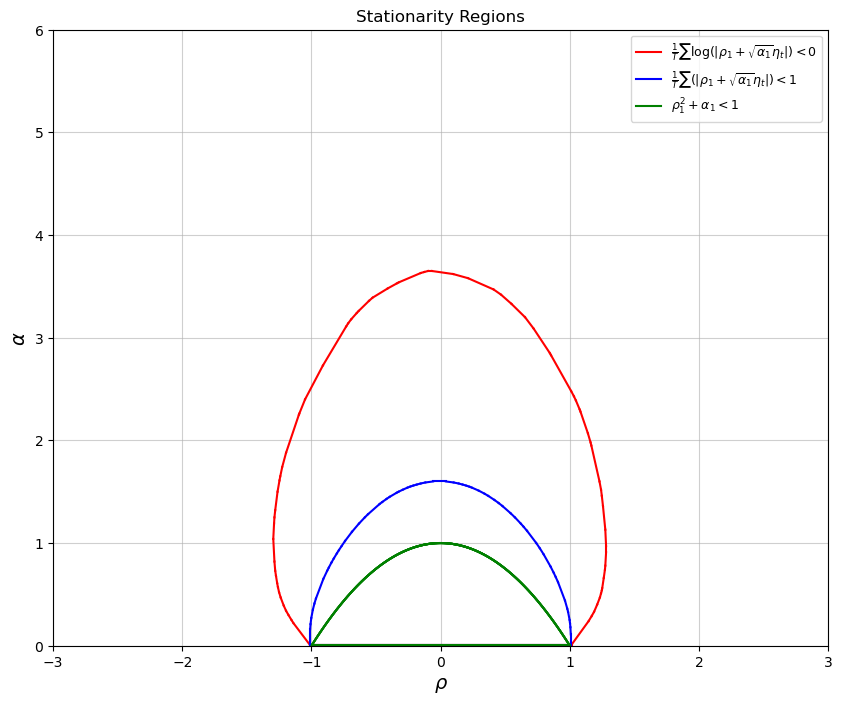

In [133]:
plt.figure(figsize=(10, 8))

# Plot Fractional Moment Condition
hull_frac = ConvexHull(frac_moment)  # Compute the convex hull once
for idx, i in enumerate(hull_frac.simplices):
    plt.plot(frac_moment[i, 0], frac_moment[i, 1], color='red', linewidth=1.5,
             label=r'$\frac{1}{T}\sum\log(|\rho_{1} +\sqrt{\alpha_{1}}\eta_{t}|) < 0$' if idx == 0 else "")

# Plot First-Order Moment Condition
hull_first = ConvexHull(first_moment)
for idx, i in enumerate(hull_first.simplices):
    plt.plot(first_moment[i, 0], first_moment[i, 1], color='blue', linewidth=1.5,
             label=r'$\frac{1}{T}\sum(|\rho_{1} +\sqrt{\alpha_{1}}\eta_{t}|) < 1$' if idx == 0 else "")


# Plot Second-roder Moment Condition
hull_first = ConvexHull(second_moment)
for idx, i in enumerate(hull_first.simplices):
    plt.plot(second_moment[i, 0], second_moment[i, 1], color='green', linewidth=1.5,
             label=r'$\rho_{1}^2 + \alpha_{1} < 1$' if idx == 0 else "")


# Add Labels, Legend, and Grid
plt.title('Stationarity Regions')
plt.xlabel(r'$\rho$', fontsize=14)
plt.ylabel(r'$\alpha$', fontsize=14)
plt.legend(fontsize=9, loc='upper right')
plt.grid(alpha=0.6)
plt.ylim(0, 6)
plt.xlim(-3, 3)
plt.show()


In [134]:
def plot_stationarity_regions(nu):
    T = 30000  # samples
    step = 1000  # grid resolution
    tolerance = 0.01  # tolerance

    eta = student.rvs(df=nu, size=T) * np.sqrt((nu - 2) / nu)  # eta ~ student-t(0,1)
    rho_range = np.linspace(-1.5, 1.5, step)
    alpha_range = np.linspace(0.01, 10, step)

    def process_alpha(alpha):
        return (
            [[rho, alpha] for rho in rho_range if np.isclose(np.mean(np.log(np.abs(rho + np.sqrt(alpha) * eta))), 0, atol=tolerance)],
            [[rho, alpha] for rho in rho_range if np.isclose(np.mean(np.abs(rho + np.sqrt(alpha) * eta)), 1, atol=tolerance)],
        )

    results = Parallel(n_jobs=-1)(delayed(process_alpha)(alpha) for alpha in alpha_range)

    frac_moment_points = [point for frac_result, _ in results for point in frac_result]
    first_moment_points = [point for _, first_result in results for point in first_result]

    second_moment_points = [[rho, 1 - rho**2] for rho in rho_range if rho**2 < 1]

    frac_moment = np.array(frac_moment_points)
    first_moment = np.array(first_moment_points)
    second_moment = np.array(second_moment_points)

    plt.figure(figsize=(10, 8))

    hull_frac = ConvexHull(frac_moment)
    for idx, i in enumerate(hull_frac.simplices):
        plt.plot(frac_moment[i, 0], frac_moment[i, 1], color='red', linewidth=1.5,
                 label=r'$\frac{1}{T}\sum\log(|\rho_{1} +\sqrt{\alpha_{1}}\eta_{t}|) < 0$' if idx == 0 else "")

    hull_first = ConvexHull(first_moment)
    for idx, i in enumerate(hull_first.simplices):
        plt.plot(first_moment[i, 0], first_moment[i, 1], color='blue', linewidth=1.5,
                 label=r'$\frac{1}{T}\sum(|\rho_{1} +\sqrt{\alpha_{1}}\eta_{t}|) < 1$' if idx == 0 else "")

    hull_first = ConvexHull(second_moment)
    for idx, i in enumerate(hull_first.simplices):
        plt.plot(second_moment[i, 0], second_moment[i, 1], color='green', linewidth=1.5,
                 label=r'$\rho_{1}^2 + \alpha_{1} < 1$' if idx == 0 else "")

    plt.title('Stationarity Regions')
    plt.xlabel(r'$\rho$', fontsize=14)
    plt.ylabel(r'$\alpha$', fontsize=14)
    plt.legend(fontsize=9, loc='upper right')
    plt.grid(alpha=0.6)
    plt.ylim(0, 6)
    plt.xlim(-3, 3)
    plt.show()
